# Изучение архитектуры на основе LeNet в PyTorch
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MVRonkin/for_course_DLCV/blob/main/workshops/WS5_PyTorch_LeNet.ipynb)

## Импорт torch

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [ ]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [ ]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 1.10
Using device: cpu
default data type: torch.float32
available number of workers: 8


*Отметим, что от части данный урок вдохнавлен [этим](https://github.com/bentrevett/pytorch-image-classification) и [этим](https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_convolutional-neural-networks/lenet.ipynb#scrollTo=FIGBGtQAyPIL) примерами.*

# Архитектура LeNet и ее модификации

В данном уроке мы рассмотрим методы описания архитектур нейронных сетей на примере архитектуры `LeNet`. Данная архитектура была одной из первых удачных попыток создания сверточных нейронных  сетей. Большенство подходов, использованных при создании архитектуры `LeNet` используются и сегодня, однако, не все. Поэтому мы реализуем адаптированный вариант `LeNet`.

Иллюстрация архитектуры `LeNet` представлена на рисунке ниже.

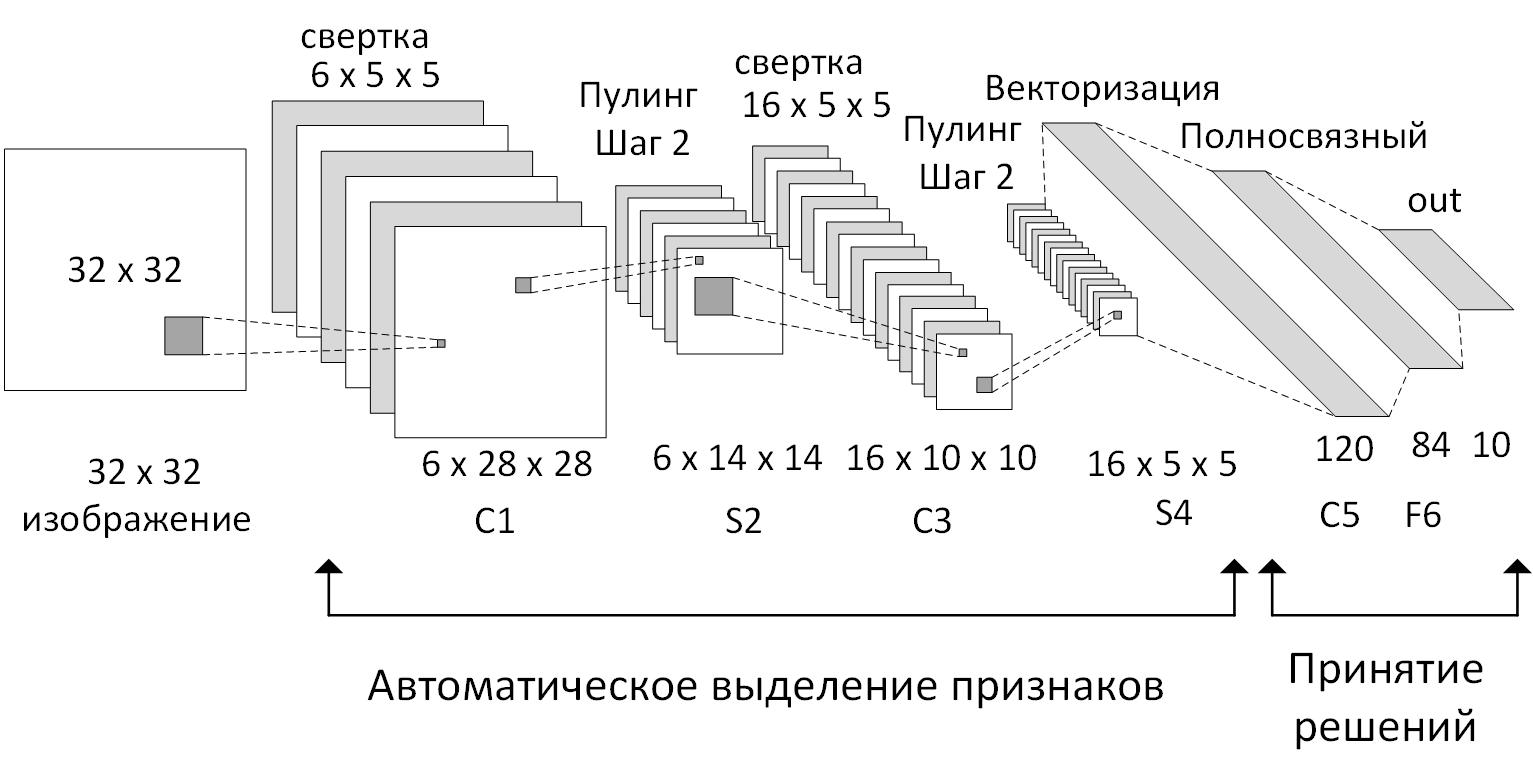
<!-- <img src="LeNet5.png" alt="LeNet5" title="LeNet5" width="650" />  -->

Для реализации архитектуры создадим класс, наследующий от `nn.Model`.

При описании архитектуры мы будем ориентироваться изображения размером $32\times 32$.

Каждый сверточный слой будет состоять из последовательности: *свертка*$\to$*активация*$\to$*пулинг*; каждый полносвязный слой будет состоять из *линейного слоя* и *активации*. Последний полносвязный слой должен иметь число выходов, равное числу классов. В нашем случае это будет $10$ классов. 

Сама архитектура сети должна быть описана в методе `forward`, который  должен иметь в качестве аргумента входной батч `x`. 

*Отметим*, что предпочтительно проводить инициализацию элементов архитектур нейронных сетей вне метода `forward`, в том числе в конструкторе класса `__init__`.



Таким образом архитектура `LeNet` имеет:
 * входной слой для изображений 32х32 (*число каналов*х32х32),
 * два сверточных слоя, 
 * каждый сверточный слой имеет также макс-пулинг субдискретизацию,
 * слой векторизации карты признаков (приобразования матрицы в вектор путем ее "разворачивания",
 * два полносвязных внутренних слоя,
 * выходной слой - слой классификации с 10 выходами.

Также особенности архитектуры:
* свертка валидная (с уменьшением размера карты признаков на размер ядра - 1)$^*$;
* ядро свертки имеет размер 5х5 (размер ядра = 5);
* макс-пулин выполняется с шагом 2 по тайлам 2х2;
* первый сверточный слой выдает 6 карт признаков 14х14 (после макс-пулинга);
* второй сверточный слой выдает 16 карт признаков 5х5 (после макс-пулинга);
* слой разворачивания принимает 16 карт признаков 5х5 и выдет вектор $1х16*5*5$ (1х400);
* первый полносвязный слой имеет 120 выходов (120 перцептронов);
* второй полносвязный слой имеет на выходе 84 перцептрона.

>$^*$Вобщем случае размер выхода свертки можно расчитать как: $$W=\frac{W−F+2P}{S}+1$$, где<ul>
    <li> $W$ входной размер, 
    <li> $F$ размер ядра свртки, 
    <li> $S$ шаг ядра,
    <li> $P$ паддинг. 

Реализуем сверточную сеть LeNet в виде класса

In [ ]:
class LeNet(nn.Module):
    
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.in_channels = in_channels
        self.n_classes   = n_classes
        
        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels, 
                                 out_channels = 6, 
                                 kernel_size  = 5)
                                        

        self.conv2   = nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 5)
        
        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2, 
                                 stride      = 2)
        
        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5, 
                             out_features = 120)
        
        self.fc2 = nn.Linear(in_features  = 120, 
                             out_features = 84)
        
        self.fc_out = nn.Linear(in_features = 84, 
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5) 
    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)        
        x = self.pool(x)
        
        #2-nd layer
        x = self.conv2(x)         
        x = torch.tanh(x)        
        x = self.pool(x)

        #flatten
        x = self.flatten(x)
        
        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)
        
        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x)
        
        # output layer
        x = self.fc_out(x)
        
        return x#torch.softmax(x, dim=1)

Отметим, что в силу простоты модели в общем случае ее можно было бы реализовать в контейнере `nn.Sequential`,
```python
model = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84), 
            nn.Tanh(),
            nn.Linear(84, 10)
            )
```
Однако,
в более сложных моделях подход `nn.Sequential` окажется не столь удобным.

In [ ]:
model = LeNet(3,10)

# from torchsummary import summary
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Посмотрим также карту параметров

In [ ]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size()) 
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc_out.weight 	 torch.Size([10, 84])
fc_out.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 62006
Number of all parameters for the model: 62006


Посмортим на выход сети в данный момент. 

In [ ]:
X = torch.randn(1, 3, 32, 32) # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())


[[ 0.03960515  0.00790074  0.05526682  0.0018464   0.11071256 -0.11194892
   0.13171871  0.0841792  -0.03771232  0.09518363]] 
 max position (Class index): 6


В данном примере мы рассмотрим набор данных `CIFAR 10`.

`Cifar10` - это классический датасет с изображениями, относящимися к 10 классам.
Каждое изображение трех-цветное и имеет размер `32` на `32` пикслея (то есть представляет тензор размером `3х32х32`).

Например `Cifar10` содержит следующие изображения.

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

Опишим набор преобразований. Мы будем использовать разные преобразования дл тестового и тренировочного наборов данных. В преобразованиях мы используем стандартную нормализацию яркости изображений, о которой речь шла в одном из предыдущих занятий.

In [ ]:
MEAN = torch.tensor([0.485, 0.456, 0.406]) 
STD  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.Resize(36),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])

Проведем загрузку набора данных. Для этого воспользуемся стандартным функционалом модуля `torchvision.datasets`. Загрузка будет происходить в два этапа: первый - тренеровочный набор данных, второй - тестовый. Для каждого набора данных задаим преобразования.

После загрузки наборов данных проверим какие классы в наборах представлены.

In [ ]:

trainset = torchvision.datasets.CIFAR10(root      = './data', 
                                        train     = True,
                                        download  = True, 
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = test_transforms)


names_classes = trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:',names_classes)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


<blockquote>
    
Отметим, что также можно загрузить свой набор данных 
и также сделать свой класс для набора даннх вида 
```python
class CustomImageDataset(Dataset):
    def __init__(self,...):
        ...

    def __len__(self):
       ...

    def __getitem__(self, idx):
        ...
        return sample
```      
Также наборы данных могут быть загружены в некоторых стандатрных формах. Например, класс `ImageFolder` позволяет загружать набор данных в виде структуры: `директория датасата->(train, val, test)->директории по классам`. Подробную информацию можно найти в документации [тут](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets) и в официальном примере [тут](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).
    
Доступные наборы посмотреть данных в модуле `torchvision.datasets` можно посмотреть при помощи команды `print(torchvision.datasets.__all__)`. Документация по данному модулю может быть найдена [тут](https://pytorch.org/vision/stable/datasets.html). 

Выделим часть тренировочного набора данных в валидационный. Для этого воспользуемся встроенным методом `random_split`. Если вы используете `GPU` метод потребует указать соответствующий генератор случайных чисел, например `torch.Generator(device='cuda')`.

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'generator':torch.Generator(device='cpu')}

trainset, validset = data.random_split(trainset,
                                           [n_train_examples, n_valid_examples], **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [ ]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


Сами по себе созданные объекты `trainset, validset` и `testset` являются экземплярами класса `torch.utils.data.dataset.Subset`, который описывает наборы данных. 

Для того, чтобы получить из соответствующего класса данные в формате загрузчика `PyTorch` можно воспользоваться классом `DataLoader` из `torch.utils.data`. Данный класс представляет загрузчик мини-батчей (пакетов) данных. Для его использования укажем размер батча, а также установим флаг перемешивания данных для тренировочной части.

Важно отметить, что экземпляры класса `DataLoader` - являются итерируемыми объектами. Работа с таким объектами может осуществляться только в цикле. Также, для единичного вызова итерируемых объектов можно воспользоваться конструкцией вида `next(iter(data))`.

In [ ]:
BATCH_SIZE = 128


if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE, **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

В конструкторе класса `DataLoader` также важно отметить аргументы `num_workers`, `pin_memory` и `generator`. 
* Аргумент `num_workers` использует субпроцессы для асинхронной загрузки данных на `CPU`. Увеличение числа работников приводит к параллелизации загрузки и предобработки данных, однако слишьком большое число работников может привести к излишней загрузке памяти (ОЗУ) и даже может заторозить работу. Число работников по умолчанию 0 - это означает, что работа будет выполнена в главном процессе.
* Аргумент `pin_memory` позволяет  зарезервировать ОЗУ в `GPU` для ускорения операций загрузки в видеоускоритель.
* Аргумент генератор позволяет специфицировать метод выборки. В некоторых случаях, при использовании `GPU` рекомендуется использовать `generator=torch.Generator(device='cuda')`. Также отметим, что в тех же случаях не стоит одновременно задавать `generator`  и  `num_workers`.

Проверим работоспособность загручика данных

In [ ]:
# get some random training images batch
dataiter = next(iter(trainloader))

# parse images and lables from batch
images, labels = dataiter

print(images.shape,labels.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


Обратите внимание на размерность данных, тут сначала идет размер выборки (число объектов в батче), затем число каналов (у нас 3 канала), а затем размер каждого объекта. Таким орбазом каждый батч является 4-х мерным. Это важно понимать для последующей обработки данных вне фреймворка `PyTorch`.

Теперь попробуем визуализировать набор данных. Для этого мы напишим функцию `imshow`. Аргументами данной функции являются: батч (`images`), число изорбажений по вертикали (`nrow`), размер изображения (`figsize`), а также значения среднего и СКО, использовавшиеся для визуализации изображений. Последние нужны для восстоновление нормализованного изображения. 

В данной функии мы выполняетм транспонирование (перестановку размерностей) для входонго бата. Это необходимо для того, чтобы привести размерности к стандартному виду для `matplotlib`. 

Также отметим, что для визуализации изображений мы должны преобразовать их из формата `torch.tensor` в `numpy.ndarray`. Если тензор находится на `GPU` мы также должны отправить его обратно на `CPU`. Для совершения этих операций мы воспользуемся стандартным методом:
`img = img.data.cpu().numpy()`.


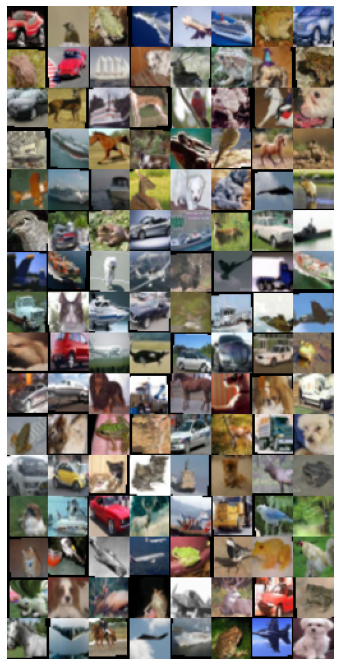

first raw classes automobile  bird  frog airplane airplane  ship  frog automobile  frog automobile  ship   dog  deer  frog   dog  frog
torch.Size([128, 3, 32, 32])


In [ ]:
def imshow(images, nrow = 8,figsize=(16,12), mean=MEAN, std=STD):
    
    img = torchvision.utils.make_grid(images, nrow = nrow, padding = 0).to(device)

    img = img.transpose(2,0).transpose(0,1)

    std = torch.as_tensor(std).to(device)
    mean = torch.as_tensor(mean).to(device)
    img = (img * std + mean)# unnormalize 
    
    img = img.data.cpu().numpy()
       
    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

Проведем инициализацию весовых параметров модели. Напомним, что для слоев с `ReLU` рекомендуется проводить инициализацию Кайменга Ге (`Kaiming He`) с нормальным распределением, а для слоев с сигмоидом инициализацию Хавьера Глора (`Xavier Glort`) с равномерным распределением. В нашем случа мы воспользуемся функцией `nn.init.kaiming_normal_`. Также проинциализируем смещения нулями для всех слоев.

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)
        
model.apply(init_weights);


Для оценки точности работы модели зададим функцию `accuracy`, которая будет подсчитывать число паравильных ответов `correct_cls` и сравнивать с числом ответов всего.

In [ ]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

Теперь зададим параметры обучения. Мы будем использовать `CrossEntropyLoss` в качестве функции потерь и оптимизацию методом `SGD with momentum` c фиксированной скоростью обучения (`LR`) и моментом $0.9$ - данное значение, как правило, рекомендуется по умолчанию.



In [ ]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
metric   = accuracy
model     = model.to(device)
criterion = criterion.to(device)

Перед началом тренировки запишем функцию `train`, которая должна реализовывать тренировку в рамках 1 эпохи. 

Функция будет выбирать все батчи из dataloader в формате `x` - данные и `y` - ответы. Затем для каждого батча будет производится расчет выхода модели `model.forward(x)` и расчет параметров `loss` (потери) и `acc` (точность). 

*Отметим* 
* В режиме тренировки модель должна иметь директиву train  `model.train()`, которая необходима в ряде элементов (например batchnorm), имеющих разное поведения при тренировке и эксплуотации.

* Также отметим, что `dataloader` вызывается при помощи `tqdm` - то есть т.н. *progress bar*.

In [ ]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Аналогично создадим функцию `evaluate`, которая позволяет оценивать работу модели, например, для валидационного или тестового наборов данных. Особенностями этой функции будут деректива `model.eval()` и `torch.no_grad()`, которые необходимы в режиме тестирования нейронной сети.

In [ ]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Запишем вспомогательную функцию расчета времени.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Проведем тренировку на 20 эпохах. В ходе проведения тренировки будем контролровать лучшую эпоху проверяя ее loss на валидации. Каждые 2 эпохи будем выводить результат работы сети в текстовом виде.

Отметим, что желающие могут найти более развернутые примеры решения задачи классификации в разделе `references` официального репозитория `torchvision` [тут](https://github.com/pytorch/vision/tree/v0.8.2/references/classification).

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()
    
    train_loss[epoch], train_acc[epoch] = train(model, 
                                                trainloader, 
                                                optimizer, 
                                                criterion, 
                                                metric,
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   validloader, 
                                                   criterion, 
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

tensor(2.4428, grad_fn=<NllLossBackward0>)
tensor(2.4459, grad_fn=<NllLossBackward0>)
tensor(2.4554, grad_fn=<NllLossBackward0>)
tensor(2.3991, grad_fn=<NllLossBackward0>)
tensor(2.4875, grad_fn=<NllLossBackward0>)
tensor(2.3230, grad_fn=<NllLossBackward0>)
tensor(2.4756, grad_fn=<NllLossBackward0>)
tensor(2.3293, grad_fn=<NllLossBackward0>)
tensor(2.2517, grad_fn=<NllLossBackward0>)
tensor(2.2950, grad_fn=<NllLossBackward0>)
tensor(2.2926, grad_fn=<NllLossBackward0>)
tensor(2.3319, grad_fn=<NllLossBackward0>)
tensor(2.3302, grad_fn=<NllLossBackward0>)
tensor(2.3286, grad_fn=<NllLossBackward0>)
tensor(2.2723, grad_fn=<NllLossBackward0>)
tensor(2.2290, grad_fn=<NllLossBackward0>)
tensor(2.3014, grad_fn=<NllLossBackward0>)
tensor(2.2347, grad_fn=<NllLossBackward0>)
tensor(2.1827, grad_fn=<NllLossBackward0>)
tensor(2.3341, grad_fn=<NllLossBackward0>)
tensor(2.2862, grad_fn=<NllLossBackward0>)
tensor(2.3163, grad_fn=<NllLossBackward0>)
tensor(2.2642, grad_fn=<NllLossBackward0>)
tensor(2.21

KeyboardInterrupt: 

Теперь попробуем визуализировать процесс обучения.

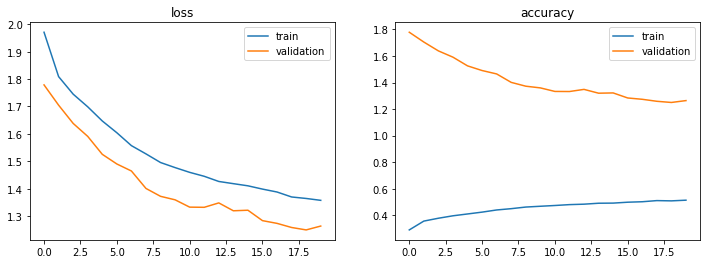

In [ ]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_loss )

Проверим точность на лучшей эпохе для тестового набора данных.

In [ ]:
model.load_state_dict(torch.load('lenet_best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 18: Test Loss: 1.275 | Test Acc: 54.33%


<blockquote>
    
Отметим, что процесс обучения может также быть дополнен некоторыми другими опциами. Так, например, процесс может быть дополнен классичесими <code>L1</code> и/или <code>L2</code> регуляризациями. Для использования общей <code>L2</code> регуляризации достаточно использовать вариант `SGD with weight_dacy` в виде:
```python
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9,weight_decay=1e-4 )
```
Если есть необходимость в установление различных вариантов регуляризации, для разных слоев, то 
функция потерь должна быть дополнена в следующем виде:
    
```python
        loss = criterion(y_pred, y)
    
        l1_regularization = 0
        l2_regularization = 0
        
        for p in model.parameters():
            l1_regularization += torch.abs(p).sum()
            l2_regularization += torch.pow(p,2).sum()     

        loss += lambda_l1*l1_regularization + lambda_l2*l2_regularization
```
    
где `lambda_l1` и `lambda_l2` - это гиперпараметры регуляризации.
Также в процесс обучения может быть интегрирована, например, возможность ранней остановки по заданным условиям. Таким условиями могут быть отсутствие изменений или рост значения потерь для валидационного набора данных.

Также отметим, что функция `SGD` позволяет реализовать метод Нестеров, при выставлении `nesterov=True`, в параметрах инициализации.

Теперь посмотрим на результаты точности по каждому классу  для тестового набора данных. 

Отметим, что в данной операции мы отдельно подсчитываем точность как отношение `class_correct` к `class_total` по каждому классу `label`, а  также собираем  классы для всех экземпляров `labels` и предсказания `predicts`.

In [ ]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():
    
    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')
        
        cls_pred = torch.argmax(y_pred, dim=1)
        
        c = (cls_pred == y).squeeze() # one-hot vector
        
        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1
    
        labels.append(y)
        predicts.append(cls_pred)
        
labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array
    
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of airplane : 59 %
Accuracy of automobile : 73 %
Accuracy of  bird : 44 %
Accuracy of   cat : 34 %
Accuracy of  deer : 40 %
Accuracy of   dog : 39 %
Accuracy of  frog : 60 %
Accuracy of horse : 61 %
Accuracy of  ship : 72 %
Accuracy of truck : 55 %


В ряде случаев, также будет важным сохраненить результатов работы сети. Для этого может быть использован, например следующий код.

In [ ]:
sorted_ids = list(range(1, n_samples + 1)) 

sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': predicts})

df['label'] = df['label'].apply(lambda x: names_classes[x])

df.to_csv('submission.csv', index=False)

Также построим т.н. `confusion_matrix` - матрицу, изображающую результаты предсказаний для каждого класса.

In [ ]:
def plot_confusion_matrix(labels, pred_labels, names_classes):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    cm = confusion_matrix(np.asarray(labels, dtype=int), 
                          np.asarray(pred_labels, dtype=int) )
    
    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)
    
    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

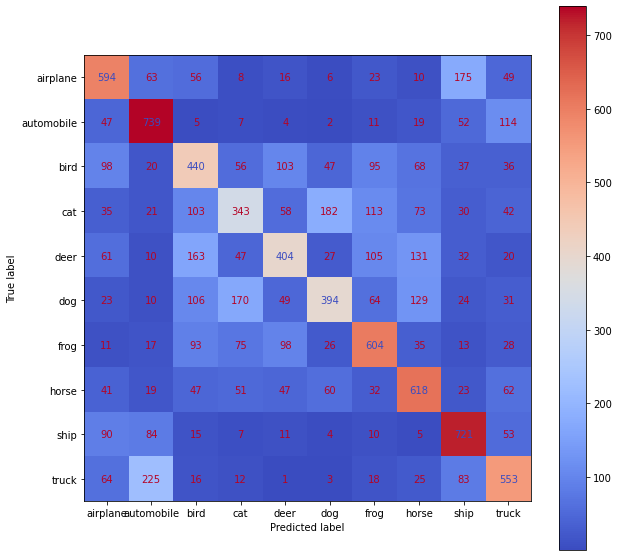

In [ ]:
plot_confusion_matrix(labels, predicts, names_classes)

Отметим, также возможность для визуализации работы нейронной сети. Попробуем визуализировать карты признаков для фильтров первого слоя.

In [ ]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    
    print(images.shape)
    
    filters = filters.cpu()

    n_images  = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)
    
    fig = plt.figure(figsize=(20, 20))

    for i in range(n_images):

        img = images[i].squeeze(0).numpy().transpose((1,2,0))
        
        img = 255*(img - img.min())/(img.max() - img.min())

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        
        ax.imshow(img.astype(int), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            
            image = image.numpy().astype(float)
            
            image = 255*(image - image.min())/(image.max() - image.min())
            
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            
            ax.imshow(image.astype(int), cmap='bone')
            
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')
    return filtered_images

torch.Size([5, 3, 32, 32])


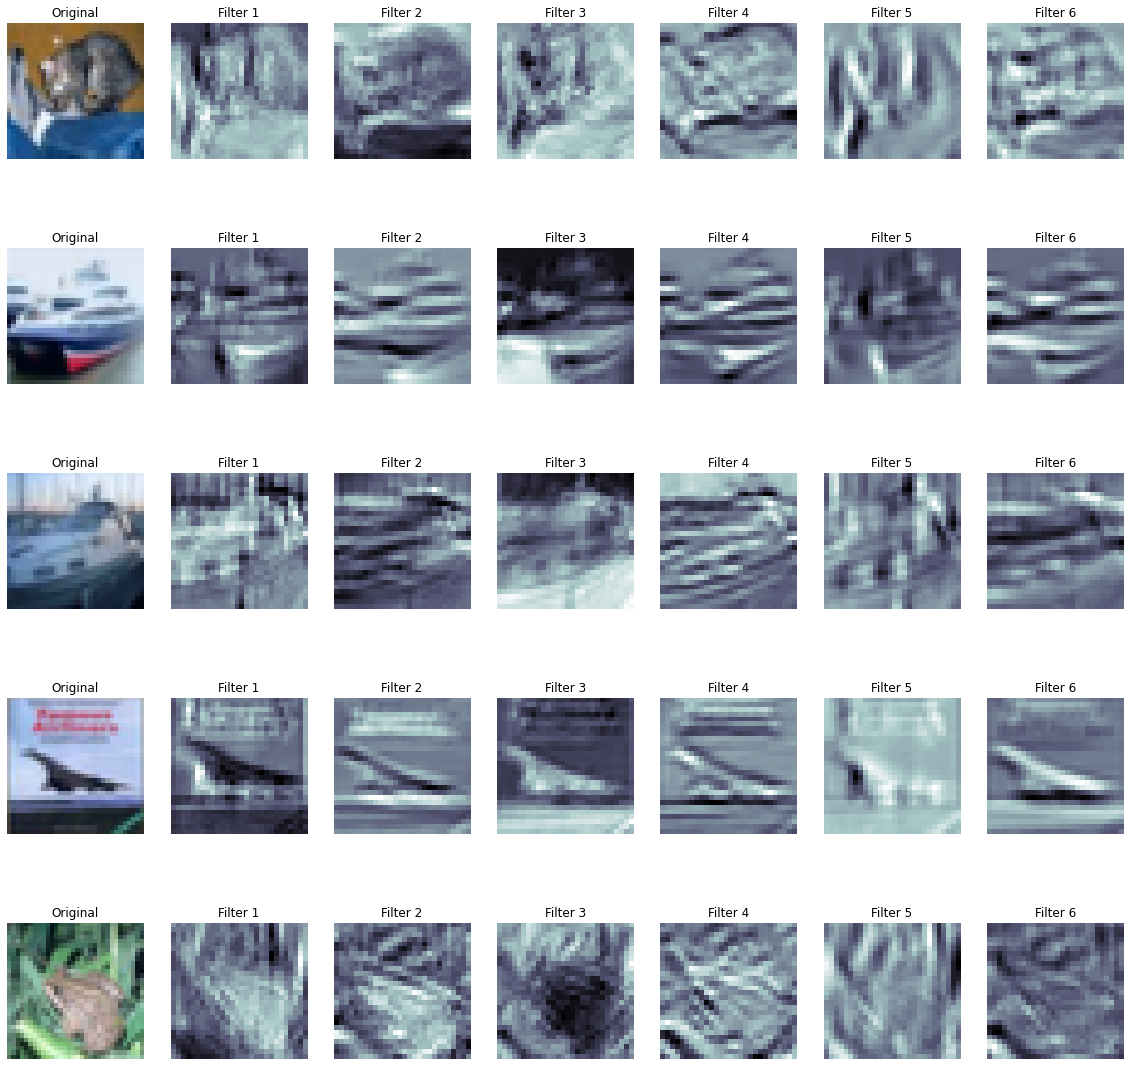

In [ ]:
N_IMAGES = 5

images = [image for image, label in [testset[i] for i in range(N_IMAGES)]]

filters = model.conv1.weight.data

filtered_images = plot_filtered_images(images, filters)

**Учебное задание**:

**Дано**: набор изобржений `test_.zip`.

Ниже будет приведен пример как его открыть.

**Задание**: достичь на данном наборе точности не менее **60%**.

Результат необходимо отправлять в формате файла `submission.csv`, пример будет показан ниже.

Для того чтобы открыть файл в виде датасета можно воспользоваться следующим примером создания своего набора даных. Вызов эелмента набора (`__getitem__`) будет давать изображение `image` и название файла `fname`. Входные аргументы: путь к тестовой директории `path_folder`, набор преорбазований `transforms` и размер выборки (может быть установлен `None`)


In [ ]:
from PIL import Image
class TestDataset(torch.utils.data.Dataset):
    def __init__(self,path_folder, transforms = None, test_size = 50):
        self.path_folder = path_folder
        self.transforms  = transforms

        if not os.path.isdir(self.path_folder):
            raise ValueError('uncorrect path to folder') 

        self.fpaths = [os.path.join(self.path_folder, fname) 
                      for fname in os.listdir(self.path_folder) 
                      if fname.lower().endswith(('.png', '.jpg', '.jpeg'))] 
        
        if test_size is not None: 
            if len(self.fpaths) < test_size:
                raise ValueError('folder is not full of images')
            else:
                self.fpaths= self.fpaths[:test_size]

    def __len__(self):
       return len(self.fpaths)

    def __getitem__(self, idx):
        image = Image.open(self.fpaths[idx])
        if self.transforms:
            image = self.transforms(image)
        fname = os.path.split(self.fpaths[idx])[1]

        return image, fname

Пример скачивания набора данных (*демонстрационный набор!*) при помощи скрипта bash:

```python
!wget --no-check-certificate 'https://courses.openedu.urfu.ru/assets/courseware/v1/d197fd4304eac9a061a03ac7ed49d6d6/asset-v1:UrFU+COMPVISION+2023_DPO_AI+type@asset+block/test_.zip' -O test_.zip
!unzip test_.zip  
!rm test_.zip
!cp -r ./content/test_submission/. test_/ 
!rm -rf ./content/
```

In [ ]:
!wget --no-check-certificate 'https://courses.openedu.urfu.ru/assets/courseware/v1/d197fd4304eac9a061a03ac7ed49d6d6/asset-v1:UrFU+COMPVISION+2023_DPO_AI+type@asset+block/test_.zip' -O test_.zip
!unzip test_.zip  
!rm test_.zip
!cp -r ./content/test_submission/. test_/ 
!rm -rf ./content/



--2023-03-10 11:39:50--  https://courses.openedu.urfu.ru/assets/courseware/v1/d197fd4304eac9a061a03ac7ed49d6d6/asset-v1:UrFU+COMPVISION+2023_DPO_AI+type@asset+block/test_.zip
Resolving courses.openedu.urfu.ru (courses.openedu.urfu.ru)... 93.88.177.51
Connecting to courses.openedu.urfu.ru (courses.openedu.urfu.ru)|93.88.177.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1230392 (1.2M) [application/zip]
Saving to: ‘test_.zip’

test_.zip           100%[===================>]   1.17M  1.39MB/s    in 0.8s    

2023-03-10 11:39:52 (1.39 MB/s) - ‘test_.zip’ saved [1230392/1230392]

Archive:  test_.zip
   creating: content/test_submission/
 extracting: content/test_submission/1753.png  
 extracting: content/test_submission/4349.png  
 extracting: content/test_submission/4844.png  
 extracting: content/test_submission/9577.png  
 extracting: content/test_submission/821.png  
 extracting: content/test_submission/4342.png  
 extracting: content/test_submission/27.png 

Создадим путь к тестовой директории, например, как это показано ниже.

In [ ]:
import os
path = os.path.join(os.getcwd(),'test_')
print(path)

/content/test_


Теперь создадим набор данных.

In [ ]:
test_ = TestDataset(path, test_transforms)

Таким образом, все что нужно тут указать - это путь к директории с изображениями. Преобразование данного набора в загрузчик можно провести стандартным способом, например `testloader  = data.DataLoader(test_,batch_size=BATCH_SIZE, **kwarg)`.

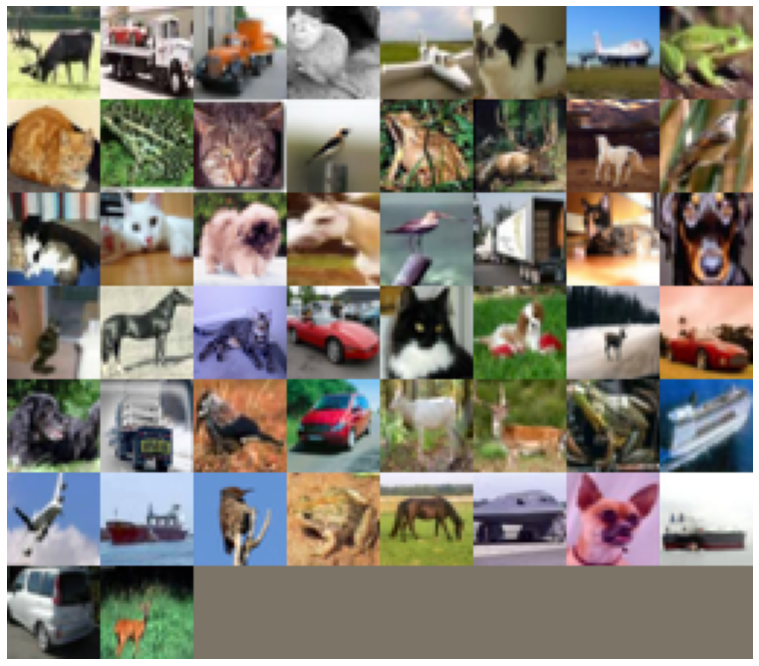

In [ ]:
testloader = data.DataLoader(test_,batch_size=BATCH_SIZE, **kwarg)

# При желании можно посмотреть на набор данных
images,_ = next(iter(testloader))
imshow(images)

*Сохранить* результаты работы сети для заданного набора данных можно примерно так, как это было показано ранее. Однако, мы предлагаем воспользоваться упрощенной  версия кода для формирования итогового файла, как это показано ниже.

>Итоговый формат предсказания должен быть представлен в виде файла с расширением `csv`, в котором должно быть три столбца: `id`, `label` и `fname`. Столбец `label` должен содержать название класса, столбец `file` - название (не путь) к файла с расширением; столбец `id` - порядковый номер файла, начиная с 1. То есть все файлы должны быть упорядочены (не перемешаны). Разделитель строк должен быть выбран `,`. Самая первая строка (нулевая) должна содержать имена колонок. Данный формат создания `csv` файла соответствует стандартному фомату без индексов для библиотеки `Pandas` (метод `to_csv(path, index=False)` для `DataFrame`). 

In [ ]:
n_samples = len(test_)

predicts = np.array([], dtype = object)
fnames   = np.array([], dtype = object)

model.eval()
with torch.no_grad():
    
    for x, fname in tqdm(testloader):

        cls_pred = torch.argmax(model.forward(x.to(device)).to('cpu'), dim=1)

        predicts = np.append(predicts, cls_pred.data.numpy())
        fnames   = np.append(fnames,fname)

df = pd.DataFrame({'id':    np.arange(1, n_samples + 1,dtype=int), 
                   'label': predicts,
                   'file':  fnames})

df['label'] = df['label'].apply(lambda x: names_classes[x])

df.to_csv('submission.csv', index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

Если вы работаете в Google Colab, то файл можно скачать, например, при помощи следующего кода
```python
from google.colab import files
files.download('/content/submission.csv')
```

In [ ]:
from google.colab import files
files.download('/content/submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>